In [2]:

%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.regression import *
from hossam.plot import *
from hossam.tensor import *
from hossam.analysis import *
from hossam.classification import *
from hossam.cluster import *
from pandas import merge, read_excel, pivot_table, melt, to_datetime, to_timedelta, DateOffset, Timestamp, Period, Series, read_csv
import numpy as np
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# 로지스틱 회귀 통계 모형
from statsmodels.api import Logit, add_constant
# 확률밀도함수
from scipy.stats import norm
from datetime import datetime


[scatterd] >WARNING> From c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [3]:
origin =read_csv("태블로용_파일4.csv", encoding='utf-8')
my_pretty_table(origin.head())

+----+----------------+--------------------------+------------------+------------+----------+------------+--------+------------+------------+------------+------------+----------------+----------+------+-----------+----------+--------------------+----------+--------------+----------+-------------+------------+------------+----------------+------------+------------+--------+------------+------------+------------+----------+-----------+------------------+----------+------------------+--------+--------+------------+--------------+------------------+--------+--------------+--------------+------+------------+------------+------------+----------------+--------------+--------------+------------+------------+-----------------+----------------+------------+------------------+------------+------------+-------------+
|    | Cohort Month   | Customer Segment(ctgr)   |   Last 15 Months | 거래일     | 등록명   | 연월       | 요일   | 종료시점   |   트레이너 |   환불내역 | 환불일     |   회원카드번호 |      CRR |   F1 |   Fc 성별 |  

In [4]:
df = origin.drop(['Cohort Month', 'Last 15 Months','Number of Orders','Unnamed: 0'], axis=1)
df =df.rename(columns = {'Customer Segment(ctgr)':'category'})

### 카테고리 정리

In [5]:
df[df['category'].isna()]

,category,거래일,등록명,연월,요일,종료시점,트레이너,환불내역,환불일,회원카드번호,...,잔여개월수,출석,통합매출,트레이너 성별,필라테스매출,헬스매출,환불사용금매출,환불시일,환불여부,환불일 일
165,NaN,2021-05-18,헬스골프,2021-05-01,NaN,2023-05-01,NaN,NaN,2021-04-30,19090081,...,24,-0.132308,2140000,0,0,1180000,0,0,0,0
759,NaN,2022-01-25,골프헬스,2022-01-01,NaN,2022-08-01,NaN,NaN,2021-12-31,22010032,...,7,0.000000,2059000,0,0,1000000,0,0,0,0
1528,NaN,2023-02-28,헬스골프,2023-02-01,NaN,2023-11-01,NaN,헬스,2023-02-24,22080009,...,9,0.000000,610000,0,0,-990000,0,199,0,24
3368,NaN,2021-08-24,헬스,2021-08-01,화,2022-01-01,NaN,NaN,2021-07-31,20070051,...,5,-0.357143,1830000,0,0,770000,0,0,0,0
4036,NaN,2022-02-19,헬스골프,2022-02-01,NaN,2024-02-01,NaN,NaN,2022-01-31,22020009,...,24,0.000000,1380000,0,0,990000,0,0,0,0
5131,NaN,2021-03-29,헬스골프,2021-03-01,NaN,2022-05-01,NaN,NaN,2021-02-28,18010105,...,14,-0.708791,1227300,0,0,742500,0,0,0,0
5297,NaN,2023-08-28,헬스골프,2023-08-01,NaN,2024-08-01,NaN,NaN,2023-07-31,21110015,...,12,0.000000,4814000,0,0,594000,0,0,0,0
5363,NaN,2023-08-30,골프헬스,2023-08-01,NaN,2024-09-01,NaN,NaN,2023-07-31,23080048,...,13,0.000000,1638000,0,0,1188000,0,0,0,0


In [6]:
df['category'].unique()

array(['헬스', '골프', '골프(골프레슨)', '환불', '헬스(PT)', '골프(PT&골프레슨)', '골프(PT)',
       nan], dtype=object)

> category.isna() 정리

- 19090081 헬스 -> 골프전환 (골프전환 총 3회 중 2회차) '골프전환'
- 22010032  (골프6개월 이후 헬스6개월) 
- 22080009 헬스 양도 후 골프 양도 받음 '골프전환'
- 20070051 헬스 양수 후 골프전환 + 골프레슨 (골프 회원권이 끝나지 않은 가운데 헬스 회원권 양수 후 추후 골프 전환) '골프'
- 22020009 골프전환
- 18010105 헬스+골프
- 21110015 헬스 6개월+골프6개월
- 23080048 골프 1개월 trial (헬스 12개월짜리)

In [7]:
df.loc[165, 'category']='골프'
df.loc[759, 'category']='골프'
df.loc[1528, 'category']='골프'
df.loc[3368, 'category']='골프(골프레슨)'
df.loc[4036, 'category']='골프'
df.loc[5131, 'category']='골프'
df.loc[5297, 'category']='골프'
df.loc[5363,'category']= '헬스'

In [8]:
df[df['category'].isna()]

,category,거래일,등록명,연월,요일,종료시점,트레이너,환불내역,환불일,회원카드번호,...,잔여개월수,출석,통합매출,트레이너 성별,필라테스매출,헬스매출,환불사용금매출,환불시일,환불여부,환불일 일


### 거래일 점검

In [9]:
df[df['회원카드번호']==22010011]

,category,거래일,등록명,연월,요일,종료시점,트레이너,환불내역,환불일,회원카드번호,...,잔여개월수,출석,통합매출,트레이너 성별,필라테스매출,헬스매출,환불사용금매출,환불시일,환불여부,환불일 일
740,헬스,2022-01-04,헬스,2022-01-01,화,2022-12-01,NaN,NaN,2021-12-31,22010011,...,11,0.0,999000,0,0,999000,0,0,0,0


### 요일 채우기

In [10]:
df[df['요일'].isna()]

,category,거래일,등록명,연월,요일,종료시점,트레이너,환불내역,환불일,회원카드번호,...,잔여개월수,출석,통합매출,트레이너 성별,필라테스매출,헬스매출,환불사용금매출,환불시일,환불여부,환불일 일
1,헬스,2020-09-18,헬스,2020-09-01,NaN,2021-11-01,NaN,NaN,2020-08-31,13120079,...,14,0.005495,1180000,0,0,1080000,0,0,0,0
4,헬스,2020-09-25,헬스,2020-09-01,NaN,2021-07-01,NaN,NaN,2020-08-31,13120139,...,10,-1.081818,990000,0,0,990000,0,0,0,0
5,골프,2020-09-11,골프,2020-09-01,NaN,2021-11-01,NaN,NaN,2020-08-31,13120199,...,14,0.274725,1420000,0,0,0,0,0,0,0
6,골프(골프레슨),2020-09-16,골프,2020-09-01,NaN,2021-03-01,NaN,NaN,2020-08-31,14010150,...,6,0.000000,1730000,0,0,0,0,0,0,0
7,골프,2020-09-22,골프,2020-09-01,NaN,2021-11-01,NaN,NaN,2020-08-31,14020045,...,14,0.675824,1550000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6294,헬스,2023-01-27,헬스,2023-01-01,NaN,2024-01-01,NaN,NaN,2022-12-31,23010018,...,12,0.000000,1488000,0,0,1188000,0,0,0,0
6300,헬스(PT),2023-01-30,헬스,2023-01-01,NaN,2023-01-01,알수없음,NaN,2022-12-31,23010024,...,0,0.000000,1695000,0,0,0,0,0,0,0
6301,헬스,2023-01-30,헬스,2023-01-01,NaN,2024-01-01,NaN,NaN,2022-12-31,23010025,...,12,0.000000,1368000,0,0,1188000,0,0,0,0
6303,골프(PT&골프레슨),2023-01-31,골프,2023-01-01,NaN,2024-01-01,문건주,NaN,2022-12-31,23010027,...,12,0.000000,6238000,2,0,0,0,0,0,0


In [11]:
df['거래일'] = to_datetime(df['거래일'], format='%Y-%m-%d')

In [12]:
# 요일 번호를 한글 요일로 매핑
weekdays = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
df['요일'] = df['거래일'].dt.weekday.map(weekdays)

# 결과 출력
print(df.요일.describe())


count     6309
unique       7
top          월
freq      1379
Name: 요일, dtype: object


In [13]:
df['양도'].fillna(0, inplace=True)
df['CRR'].fillna(0, inplace=True)
df['환불내역'].fillna("", inplace=True)
df['요일'].fillna("", inplace=True) 
df['트레이너'].fillna("", inplace=True)

In [14]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6309 entries, 0 to 6308
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   category  6309 non-null   object        
 1   거래일       6309 non-null   datetime64[ns]
 2   등록명       6309 non-null   object        
 3   연월        6309 non-null   object        
 4   요일        6309 non-null   object        
 5   종료시점      6309 non-null   object        
 6   트레이너      6309 non-null   object        
 7   환불내역      6309 non-null   object        
 8   환불일       6309 non-null   object        
 9   회원카드번호    6309 non-null   int64         
 10  CRR       6309 non-null   float64       
 11  F1        6309 non-null   int64         
 12  Fc 성별     6309 non-null   int64         
 13  Gx매출      6309 non-null   int64         
 14  Pt매출      6309 non-null   int64         
 15  개월수       6309 non-null   int64         
 16  거래일 일     6309 non-null   int64         
 17  거래횟수      6309

In [16]:
df1 = df.drop(['회원카드번호', '종료시점','매출액2','매출액','상환액매출','부가서비스사용','레슨여부','연월','등록명','문화생활비지출','소비자심리지수','거래일 일','환불일 일','거래일','환불일'], axis=1)
df2 = df1.astype({'category':'category','월':'category','분기':'category', '환불여부':'category','양도':'category','이탈여부':'category', '환불내역':'category', '요일':"category",
                    '골프전환':'category','단체회원':'category','Fc 성별':'category','트레이너':'category','트레이너 성별':'category'})
# df1.dtypesdf2 = df1.astype({'회원카드번호':'category','연월':'category','월':'category','분기':'category','종료시점':'category','등록명':'category', '환불여부':'category','양도':'category','이탈여부':'category', '환불내역':'category', '요일':"category",
                    # '부가서비스사용':'category','레슨여부':'category','골프전환':'category','단체회원':'category','FC 성별':'category','트레이너':'category','트레이너 성별':'category'})

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6309 entries, 0 to 6308
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   category  6309 non-null   category
 1   요일        6309 non-null   category
 2   트레이너      6309 non-null   category
 3   환불내역      6309 non-null   category
 4   CRR       6309 non-null   float64 
 5   F1        6309 non-null   int64   
 6   Fc 성별     6309 non-null   category
 7   Gx매출      6309 non-null   int64   
 8   Pt매출      6309 non-null   int64   
 9   개월수       6309 non-null   int64   
 10  거래횟수      6309 non-null   int64   
 11  결제시점      6309 non-null   int64   
 12  골프레슨매출    6309 non-null   int64   
 13  골프매출      6309 non-null   int64   
 14  골프전환      6309 non-null   category
 15  광고        6309 non-null   int64   
 16  단체회원      6309 non-null   category
 17  라카매출      6309 non-null   int64   
 18  미수액       6309 non-null   int64   
 19  분기        6309 non-null   category
 20  분실      

### Labelling

In [18]:
라벨링변수 =  df2.select_dtypes(include=['category']).columns.tolist()
라벨링변수

['category',
 '요일',
 '트레이너',
 '환불내역',
 'Fc 성별',
 '골프전환',
 '단체회원',
 '분기',
 '양도',
 '월',
 '이탈여부',
 '트레이너 성별',
 '환불여부']

In [23]:
for i in range(len(라벨링변수)):
    df2=my_labelling(df2,라벨링변수[i])
my_pretty_table(df2.head())

+-------------------+---------+
| category          |   label |
|-------------------+---------|
| 골프              |       0 |
| 골프(PT&골프레슨) |       1 |
| 골프(PT)          |       2 |
| 골프(골프레슨)    |       3 |
| 헬스              |       4 |
| 헬스(PT)          |       5 |
| 환불              |       6 |
+-------------------+---------+
+--------+---------+
| 요일   |   label |
|--------+---------|
| 금     |       0 |
| 목     |       1 |
| 수     |       2 |
| 월     |       3 |
| 일     |       4 |
| 토     |       5 |
| 화     |       6 |
+--------+---------+
+------------+---------+
| 트레이너   |   label |
|------------+---------|
|            |       0 |
| 강대현     |       1 |
| 고형범     |       2 |
| 금소현     |       3 |
| 김강       |       4 |
| 김강민     |       5 |
| 김광현     |       6 |
| 김영찬     |       7 |
| 문건주     |       8 |
| 박근열     |       9 |
| 백희정     |      10 |
| 서하은     |      11 |
| 알수없음   |      12 |
| 오수정     |      13 |
| 이상준     |      14 |
| 이상현     |      15 |
| 이수환     |      16 |


### 시각화

#### 상관관계

In [14]:
# sns.pairplot(df2, hue='category')
# plt.show()

In [14]:

# '소비자심리지수','문화생활비지출','연월','FC 성별','분기','상환액매출','일일입장','개월수','매출액','분실','레슨여부','필라테스매출','통합매출','부가서비스사용'

,count,mean,std,min,25%,50%,75%,max
CRR,6309.0,-5.760076,1.590138e+01,-7.753304e+01,-6.091954,-0.896057,1.245847,1.284996e+01
F1,6309.0,3154.000000,1.821396e+03,0.000000e+00,1577.000000,3154.000000,4731.000000,6.308000e+03
Gx매출,6309.0,464.098906,1.539578e+04,0.000000e+00,0.000000,0.000000,0.000000,8.880000e+05
Pt매출,6309.0,281143.716120,1.037132e+06,-3.300000e+06,0.000000,0.000000,0.000000,1.562500e+07
개월수,6309.0,7.867015,5.908591e+00,-2.400000e+01,4.000000,12.000000,12.000000,2.400000e+01
...,...,...,...,...,...,...,...,...
이탈여부_1,6309.0,0.566968,4.955343e-01,0.000000e+00,0.000000,1.000000,1.000000,1.000000e+00
이탈여부_2,6309.0,0.191948,3.938636e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
트레이너 성별_1,6309.0,0.010778,1.032655e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
트레이너 성별_2,6309.0,0.022666,1.488482e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00


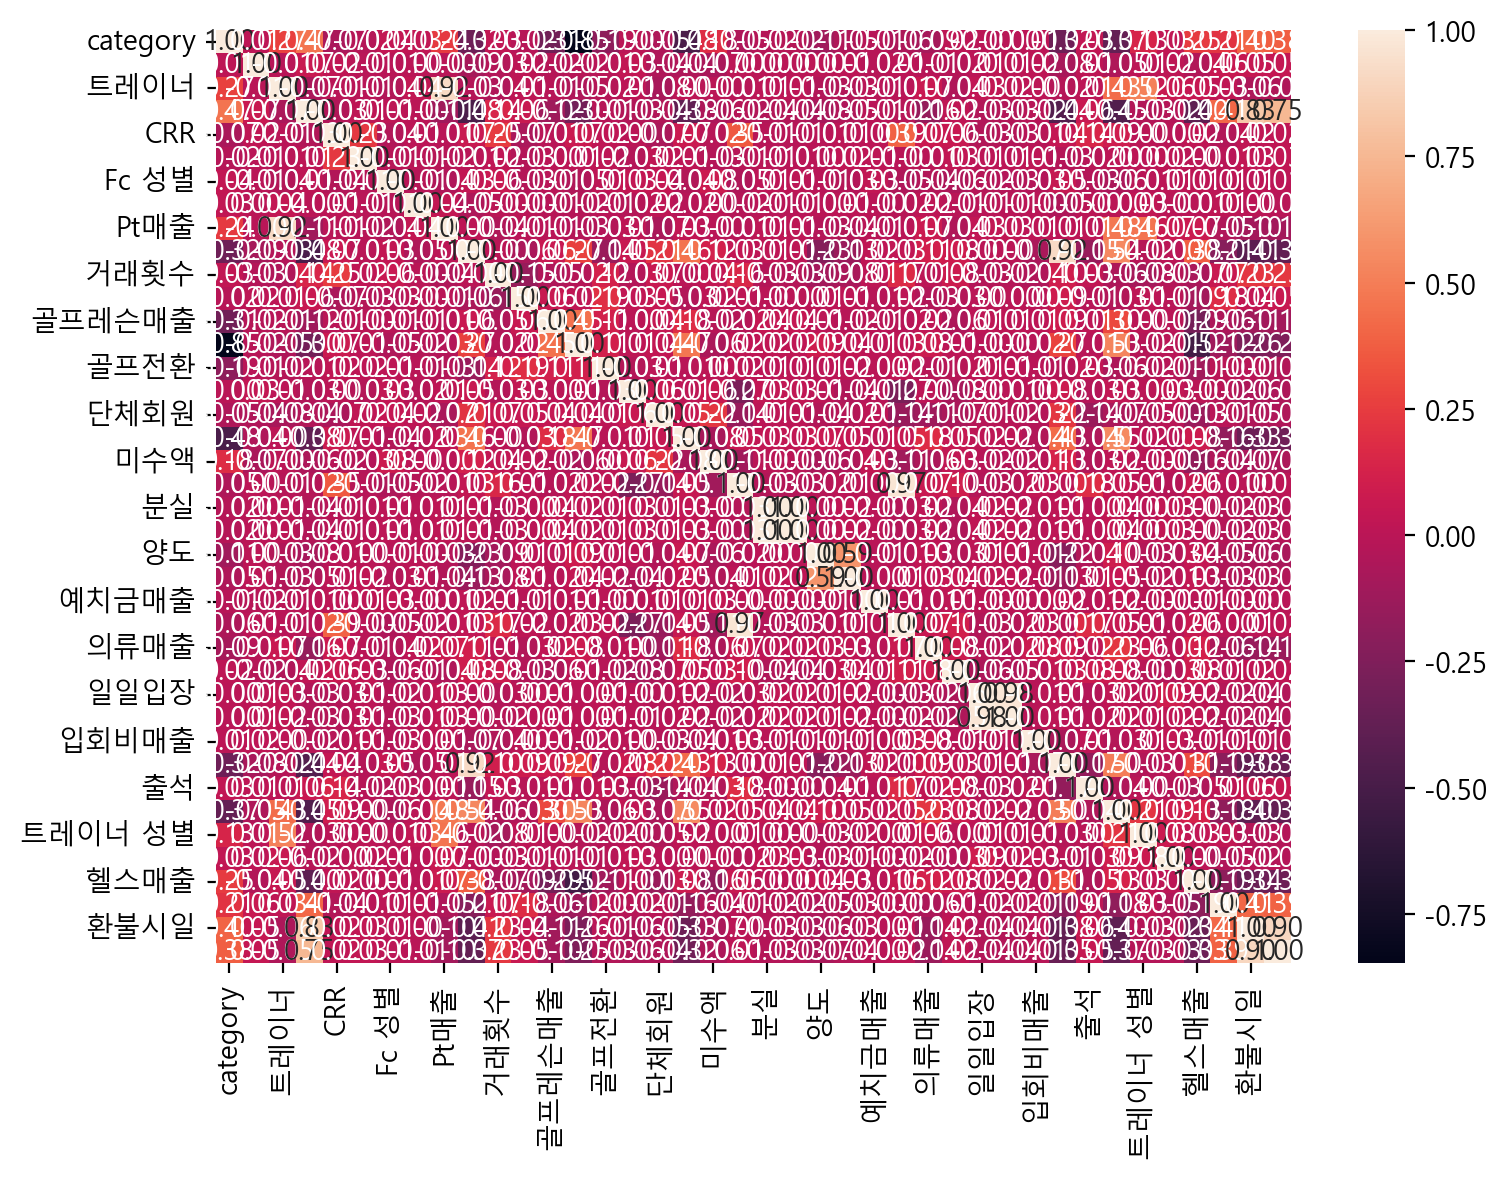

+-------------------------------------+---------------+--------------+----------+
|                                     |   correlation |      p-value | result   |
|-------------------------------------+---------------+--------------+----------|
| ('category', '요일')                |     0.0139419 |     0.268195 | False    |
| ('category', '트레이너')            |      0.267226 | 1.28127e-103 | True     |
| ('category', '환불내역')            |      0.465016 |            0 | True     |
| ('category', 'CRR')                 |    -0.0698441 |  2.80258e-08 | True     |
| ('category', 'F1')                  |       -0.0184 |     0.143925 | False    |
| ('category', 'Fc 성별')             |     0.0369688 |    0.0033159 | True     |
| ('category', 'Gx매출')              |     0.0312744 |    0.0129837 | True     |
| ('category', 'Pt매출')              |      0.239278 |   7.5141e-83 | True     |
| ('category', '개월수')              |     -0.324276 |  2.1251e-154 | True     |
| ('category', '거래횟수')            |

In [45]:
my_correlation(df2, method='s', heatmap=True, dpi=200, figsize=(8, 6))

이탈여부에 영향을 미치지 않는 변수 제거
| 변수 | 상관계수 (correlation) | p-value | 유의미 여부 (result) |
|--|--|--|--|
|('이탈여부', '요일')                |    -0.0225988 |    0.0726727 | False    |
| ('이탈여부', '환불내역')            |     0.0231938 |     0.065454 | False    |
| ('이탈여부', 'Gx매출')              |   -0.00663182 |     0.598428 | False    |
| ('이탈여부', '골프매출')            |    0.00905499 |     0.472077 | False    |
| ('이탈여부', '골프전환')            |    -0.0155403 |     0.217136 | False    |
| ('이탈여부', '예치금매출')          |     0.0148127 |     0.239438 | False    |
| ('이탈여부', '입회비매출')          |    -0.0125772 |     0.317872 | False    |
| ('이탈여부', '트레이너 성별')       |   -0.00462605 |     0.713341 | False    |
| ('이탈여부', '환불사용금매출')      |    0.00532878 |     0.672164 | False    |
| ('이탈여부', '환불시일')            |      0.024296 |    0.0536421 | False    |
| ('이탈여부', '환불여부')            |     0.0238946 |    0.0577192 | False    |


In [24]:
삭제할변수=[
        '요일',
        '환불내역',
        'Gx매출',
        '골프매출',
        '골프전환',
        '예치금매출',
        '입회비매출',
        '트레이너 성별',
        '환불사용금매출',
        '환불시일',
        '환불여부'
    ]

In [25]:
df3=df2.drop(columns=삭제할변수)
df3.columns

Index(['category', '트레이너', 'CRR', 'F1', 'Fc 성별', 'Pt매출', '개월수', '거래횟수', '결제시점',
       '골프레슨매출', '광고', '단체회원', '라카매출', '미수액', '분기', '분실', '분실매출', '양도',
       '양도비매출', '월', '의류매출', '이탈여부', '일일입장', '일일입장매출', '잔여개월수', '출석', '통합매출',
       '필라테스매출', '헬스매출'],
      dtype='object')

| 변수 | 상관계수 (correlation) | p-value | 유의미 여부 (result) |
|--|--|--|--|
| ('의류매출', 'category')            |     -0.088332 |  2.08775e-12 | True     |
| ('이탈여부', '트레이너')            |    -0.0411523 |   0.00107762 | True     |
| ('이탈여부', 'CRR')                 |     0.0606785 |  1.41318e-06 | True     |
| ('이탈여부', 'F1')                  |     0.0307907 |     0.014454 | True     |
| ('이탈여부', 'Fc 성별')             |    -0.0591842 |  2.54933e-06 | True     |
| ('이탈여부', 'Pt매출')              |    -0.0434044 |  0.000563671 | True     |
| ('이탈여부', '개월수')              |     0.0832366 |  3.55323e-11 | True     |
| ('이탈여부', '거래횟수')            |     0.0803409 |  1.65362e-10 | True     |
| ('이탈여부', '결제시점')            |    -0.0255732 |     0.042236 | True     |
| ('이탈여부', '골프레슨매출')        |    -0.0554738 |  1.03962e-05 | True     |
| ('이탈여부', '광고')                |    -0.0772919 |  7.88538e-10 | True     |
| ('이탈여부', '단체회원')            |    -0.0672737 |  8.86877e-08 | True     |
| ('이탈여부', '라카매출')            |      0.051616 |  4.10054e-05 | True     |
| ('이탈여부', '미수액')              |     0.0284426 |    0.0238721 | True     |
| ('이탈여부', '분기')                |      0.100749 |  1.04647e-15 | True     |
| ('이탈여부', '분실')                |    -0.0423649 |  0.000763062 | True     |
| ('이탈여부', '분실매출')            |    -0.0423561 |     0.000765 | True     |
| ('이탈여부', '양도')                |    -0.0284722 |     0.023726 | True     |
| ('이탈여부', '양도비매출')          |     0.0444586 |  0.000411874 | True     |
| ('이탈여부', '월')                  |      0.105564 |  4.21747e-17 | True     |
| ('이탈여부', '의류매출')            |     0.0806924 |  1.37595e-10 | True     |
| ('이탈여부', '일일입장')            |    -0.0570975 |  5.67871e-06 | True     |
| ('이탈여부', '일일입장매출')        |    -0.0508858 |  5.26274e-05 | True     |
| ('이탈여부', '잔여개월수')          |     0.0297209 |    0.0182375 | True     |
| ('이탈여부', '출석')                |     0.0829301 |  4.19175e-11 | True     |
| ('이탈여부', '통합매출')            |      0.081532 |  8.84164e-11 | True     |
| ('이탈여부', '필라테스매출')        |    -0.0292073 |    0.0203438 | True     |
| ('이탈여부', '헬스매출')            |     0.0824346 |  5.46872e-11 | True     |

이탈여부에 영향을 미치는 변수
| 변수 | 상관계수 (correlation) | p-value | 유의미 여부 (result) |
|--|--|--|--|
| 요일 | 0.0644865 | 2.95284e-07 | True |
| 트레이너 | -0.0411523 | 0.00107762 | True |
| CRR | 0.0606785 | 1.41318e-06 | True |
| F1 | 0.0307907 | 0.014454 | True |
| Fc 성별 | -0.0591842 | 2.54933e-06 | True |
| Pt매출 | -0.0434044 | 0.000563671 | True |
| 개월수 | 0.0832366 | 3.55323e-11 | True |
| 거래횟수 | 0.0803409 | 1.65362e-10 | True |
| 결제시점 | -0.0255732 | 0.042236 | True |
| 골프레슨매출 | -0.0554738 | 1.03962e-05 | True |
| 광고 | -0.0772919 | 7.88538e-10 | True |
| 단체회원 | -0.0672737 | 8.86877e-08 | True |
| 라카매출 | 0.051616 | 4.10054e-05 | True |
| 미수액 | 0.0284426 | 0.0238721 | True |
| 분기 | 0.100749 | 1.04647e-15 | True |
| 분실 | -0.0423649 | 0.000763062 | True |
| 분실매출 | -0.0423561 | 0.000765 | True |
| 양도 | -0.0284722 | 0.023726 | True |
| 양도비매출 | 0.0444586 | 0.000411874 | True |
| 월 | 0.105564 | 4.21747e-17 | True |
| 의류매출 | 0.0806924 | 1.37595e-10 | True |
| 일일입장 | -0.0570975 | 5.67871e-06 | True |
| 일일입장매출 | -0.0508858 | 5.26274e-05 | True |
| 잔여개월수 | 0.0297209 | 0.0182375 | True |
| 출석 | 0.0829301 | 4.19175e-11 | True |
| 통합매출 | 0.081532 | 8.84164e-11 | True |
| 필라테스매출 | -0.0292073 | 0.0203438 | True |
| 헬스매출 | 0.0824346 | 5.46872e-11 | True |


### VIF

In [28]:
 # VIF
if len(df3.columns) > 1:
    vif = [
        variance_inflation_factor(df3, list(df3.columns).index(v))
        for i, v in enumerate(df3.columns)
    ]
else:
    vif = 0
result = DataFrame({
    "독립변수": df3.columns,
    "VIF": vif
})
result.sort_values(by="VIF", ascending=False)

,독립변수,VIF
0,category,4.884866
4,Fc 성별,4.722168
6,개월수,4.149395
7,거래횟수,3.699854
3,F1,3.573348
19,이탈여부,3.163059
14,분기,2.743168
12,라카매출,2.491325
1,트레이너,2.452318
5,Pt매출,2.335353


In [27]:
df3.drop(['분실매출'], axis=1, inplace=True)
df3.drop(['월'], axis=1, inplace=True)
df3.drop(['잔여개월수'], axis=1, inplace=True)
df3.drop(['일일입장매출'], axis=1, inplace=True)
df3.drop(['통합매출'], axis=1, inplace=True)

### 범주 데이터 처리

#### Dummies

In [29]:
더미화변수 = ['category','트레이너','Fc 성별','단체회원','분기','양도','이탈여부']
df4 = pd.get_dummies(df3, columns = 더미화변수, drop_first=True)
df4.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRR,6309.0,-5.760076,1.590138e+01,-7.753304e+01,-6.091954,-0.896057,1.245847,1.284996e+01
F1,6309.0,3154.000000,1.821396e+03,0.000000e+00,1577.000000,3154.000000,4731.000000,6.308000e+03
Pt매출,6309.0,281143.716120,1.037132e+06,-3.300000e+06,0.000000,0.000000,0.000000,1.562500e+07
개월수,6309.0,7.867015,5.908591e+00,-2.400000e+01,4.000000,12.000000,12.000000,2.400000e+01
거래횟수,6309.0,1.688223,1.059257e+00,1.000000e+00,1.000000,1.000000,2.000000,1.600000e+01
결제시점,6309.0,-0.456966,4.184580e+00,-4.500000e+01,0.000000,0.000000,0.000000,2.200000e+01
골프레슨매출,6309.0,66064.723411,2.487311e+05,-7.200000e+05,0.000000,0.000000,0.000000,2.500000e+06
광고,6309.0,0.378507,4.850533e-01,0.000000e+00,0.000000,0.000000,1.000000,1.000000e+00
라카매출,6309.0,70258.440323,9.610546e+04,-3.600000e+05,0.000000,60000.000000,120000.000000,5.400000e+05
미수액,6309.0,53550.994611,4.468039e+05,-3.300000e+06,0.000000,0.000000,0.000000,2.960000e+07


In [30]:
df4.to_excel('변수정리데이터_더미.xlsx')

#### 타겟인코딩

In [31]:
# Target Encoding을 위한 함수 정의
def target_encode(df, col, target):
    means = df.groupby(col)[target].mean()
    df[col + '_encoded'] = df[col].map(means)
    return df

# 각 범주형 변수에 대해 Target Encoding 수행
for col in ['category', '트레이너', 'Fc 성별', '단체회원', '분기', '양도']:
    df5 = target_encode(df3, col, '이탈여부')


In [36]:
df5.to_excel("변수정리데이터_타겟인코딩.xlsx")

#### 카테고리 인코딩

In [38]:
# ! pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   -- ------------------------------------- 1.7/24.0 MB 35.1 MB/s eta 0:00:01
   ----- ---------------------------------- 3.6/24.0 MB 32.3 MB/s eta 0:00:01
   -------- ------------------------------- 5.4/24.0 MB 31.2 MB/s eta 0:00:01
   ---------- ----------------------------- 6.4/24.0 MB 27.2 MB/s eta 0:00:01
   ------------- -------------------------- 8.2/24.0 MB 23.8 MB/s eta 0:00:01
   --------------- ------------------------ 9.3/24.0 MB 23.8 MB/s eta 0:00:01
   ----------------- ---------------------- 10.5/24.0 MB 24.2 MB/s eta 0:00:01
   ------------------- -------------------- 11.6/24.0 MB 22.6 MB/s eta 0:00:01
   ---------------------- ----------------- 13.8/24.0 MB 23.4 MB/s eta 0:00:01
   ------------------------- -------------- 15.2/24.0 MB 22.6 MB/s eta 0:00:01
   ----------------------------- ---------- 17.6/24.0 MB 27.3 MB/s eta 0:00:01
   --------------------------------- ------ 19.9/24.0 MB 36.4 MB/s 

DEPRECATION: mecab-python 0.996-ko-0.9.2-msvc has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
# Word2Vec을 사용한 범주 임베딩
from gensim.models import Word2Vec

# 범주별 데이터를 준비 (예시)
categories = df3[['category', '트레이너', 'Fc 성별', '단체회원', '분기', '양도']].values.tolist()

# Word2Vec 모델 학습 (vector_size를 10으로 설정)
model = Word2Vec(categories, vector_size=10, window=5, min_count=1, sg=1)

# 범주 임베딩 추출
category_embeddings = {word: model.wv[word] for word in model.wv.index_to_key}

# 예시 데이터셋에서 범주형 변수를 임베딩 벡터로 변환
embedded_data = pd.DataFrame()
for col in df3.columns:
    if col in category_embeddings:
        embeddings = np.vstack(df3[col].map(lambda x: model.wv[x] if x in model.wv else np.zeros(model.vector_size)))
        for i in range(model.vector_size):
            embedded_data[f'{col}_dim{i+1}'] = embeddings[:, i]
    else:
        embedded_data[col] = df3[col]  # 범주 임베딩이 필요 없는 열은 그대로 복사

embedded_data.head(10)
df6= embedded_data.drop(columns=['category', '트레이너', 'Fc 성별', '단체회원', '분기', '양도'])
df6.to_excel("변수정리데이터_카테고리인코딩.xlsx")